Forward pass:
a: 0.5001
b: 0.71
c: 1.5651709999999999
d: 0.9162542319535778

Backward pass (gradients):
a.grad: 0.27441769195044236
b.grad: 0.24073332145898163
c.grad: 0.16047818242715928
d.grad: 1.0
Forward pass:
x1: 0.5000
x2: 0.7000
w1: -0.1384
w2: -0.0147
b: -0.0403
x1*w1: -0.0692
x2*w2: -0.0103
x1*w1 + x2*w2: -0.0795
x1*w1 + x2*w2 + b: -0.1198
tanh(x1*w1 + x2*w2 + b): -0.1192

Backward pass (gradients):
x1.grad: -0.1364
x2.grad: -0.0144
w1.grad: 0.4929
w2.grad: 0.6901
b.grad: 0.9858
x1*w1.grad: 0.9858
x2*w2.grad: 0.9858
x1*w1 + x2*w2.grad: 0.9858
x1*w1 + x2*w2 + b.grad: 0.9858
tanh(x1*w1 + x2*w2 + b).grad: 1.0000


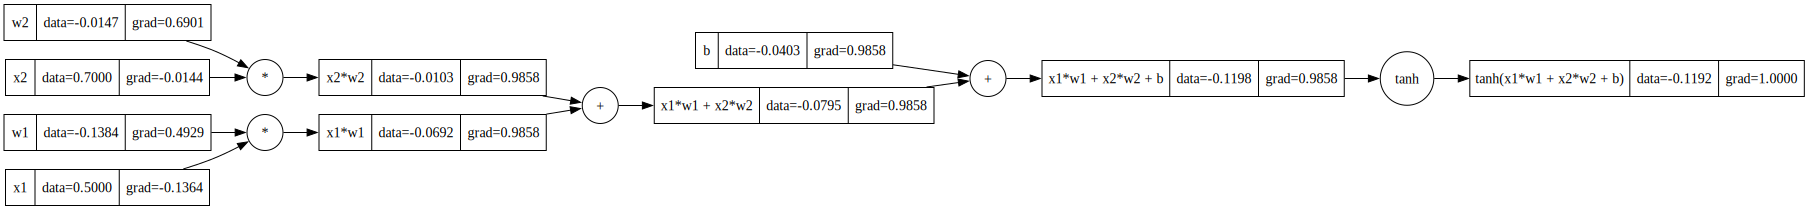

In [37]:
import math
from graphviz import Digraph
import random


class Value:
    
    def __init__(self, data, _children=(), _op='',  name=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)  # parents
        self._op = _op               # operation
        self.name = name
        self._backward = lambda: None  # will define later

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    # Addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    # Subtraction
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)

    # Negation
    def __neg__(self):
        out = Value(-self.data, (self,), 'neg')
        def _backward():
            self.grad += -1 * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * (other ** -1)


    def __pow__(self, n):
        assert isinstance(n, (int, float))
        out = Value(self.data ** n, (self,), f'**{n}')

        def _backward():
            self.grad += n * (self.data ** (n - 1)) * out.grad

        out._backward = _backward
        return out
    # Multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward
        return out

    # Backpropagation
    def backward(self):
        topo = []
        visited = set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)
        build(self)

        # Seed gradient
        self.grad = 1.0

        # Traverse in reverse topological order
        for v in reversed(topo):
            v._backward()






          # Right-side operations for Python numbers
    def __radd__(self, other): 
        return self + other

    def __rsub__(self, other): 
        return Value(other) - self

    def __rmul__(self, other): 
        return self * other

    def __rtruediv__(self, other): 
        return Value(other) / self

    def __rpow__(self, other):
        return Value(other) ** self


def trace(root):
        nodes, edges = set(), set()

        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build(child)

        build(root)
        return nodes, edges



def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # Create the 3-field rectangle
        var_name = n.name if n.name else ''
        label = f"{{ {var_name} | data={n.data:.4f} | grad={n.grad:.4f} }}"
        dot.node(name=uid, label=label, shape='record')

        # If there's an operation, create a circle for it
        if n._op:
            op_uid = uid + "_op"
            dot.node(name=op_uid, label=n._op, shape='circle')
            # Connect operation circle to this value rectangle
            dot.edge(op_uid, uid)
            # Connect operands (children) to the operation circle
            for child in n._prev:
                dot.edge(str(id(child)), op_uid)

    return dot


  

# Inputs
a = Value(0.5001, name='a')
b = Value(0.71, name='b')

# Compute intermediates
t1 = a * b
t1.name = 't1'

t2 = t1 + b
t2.name = 't2'

c = t2 + a
c.name = 'c'

d = c.tanh()
d.name = 'd'

# Forward pass
print("Forward pass:")
print("a:", a.data)
print("b:", b.data)
print("c:", c.data)
print("d:", d.data)

# Backward pass
d.backward()
print("\nBackward pass (gradients):")
print("a.grad:", a.grad)
print("b.grad:", b.grad)
print("c.grad:", c.grad)
print("d.grad:", d.grad)

# Draw graph
draw_dot(d)

x1 = Value(0.5, name='x1')
x2 = Value(0.7, name='x2')

# Weights
w1 = Value(random.uniform(-1, 1), name='w1')
w2 = Value(random.uniform(-1, 1), name='w2')
b  = Value(random.uniform(-1, 1), name='b')  # bias

# Forward pass with descriptive names
x1w1 = x1 * w1
x1w1.name = 'x1*w1'

x2w2 = x2 * w2
x2w2.name = 'x2*w2'

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.name = 'x1*w1 + x2*w2'

x1w1_x2w2_b = x1w1_x2w2 + b
x1w1_x2w2_b.name = 'x1*w1 + x2*w2 + b'

out = x1w1_x2w2_b.tanh()
out.name = 'tanh(x1*w1 + x2*w2 + b)'

# Display forward pass
print("Forward pass:")
for v in [x1, x2, w1, w2, b, x1w1, x2w2, x1w1_x2w2, x1w1_x2w2_b, out]:
    print(f"{v.name}: {v.data:.4f}")

# Backward pass
out.backward()

# Display gradients
print("\nBackward pass (gradients):")
for v in [x1, x2, w1, w2, b, x1w1, x2w2, x1w1_x2w2, x1w1_x2w2_b, out]:
    print(f"{v.name}.grad: {v.grad:.4f}")

# Draw graph
draw_dot(out)


Forward pass:
x1: 0.5000
x2: 0.7000
w1: -0.4281
w2: 0.1831
b: 0.3221
x1*w1: -0.2140
x2*w2: 0.1282
x1*w1 + x2*w2: -0.0859
x1*w1 + x2*w2 + b: 0.2363
tanh(x1*w1 + x2*w2 + b): 0.2320

Backward pass (gradients):
x1.grad: -0.4050
x2.grad: 0.1733
w1.grad: 0.4731
w2.grad: 0.6623
b.grad: 0.9462
x1*w1.grad: 0.9462
x2*w2.grad: 0.9462
x1*w1 + x2*w2.grad: 0.9462
x1*w1 + x2*w2 + b.grad: 0.9462
tanh(x1*w1 + x2*w2 + b).grad: 1.0000


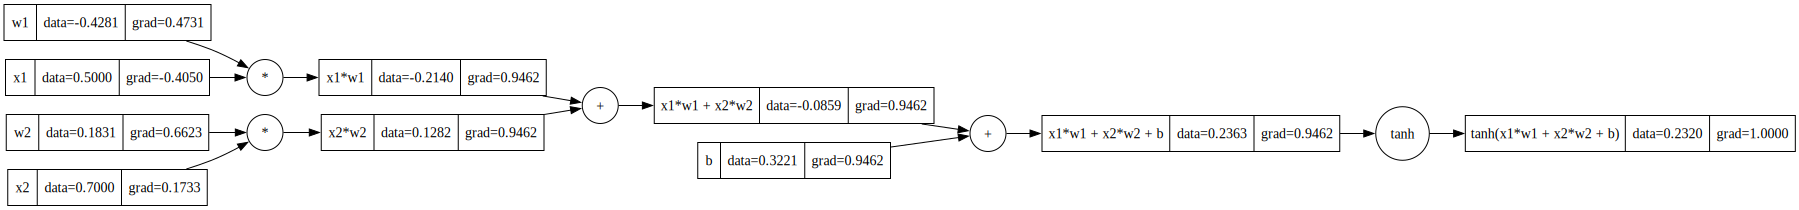

In [38]:

x1 = Value(0.5, name='x1')
x2 = Value(0.7, name='x2')

# Weights
w1 = Value(random.uniform(-1, 1), name='w1')
w2 = Value(random.uniform(-1, 1), name='w2')
b  = Value(random.uniform(-1, 1), name='b')  # bias

# Forward pass with descriptive names
x1w1 = x1 * w1
x1w1.name = 'x1*w1'

x2w2 = x2 * w2
x2w2.name = 'x2*w2'

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.name = 'x1*w1 + x2*w2'

x1w1_x2w2_b = x1w1_x2w2 + b
x1w1_x2w2_b.name = 'x1*w1 + x2*w2 + b'

out = x1w1_x2w2_b.tanh()
out.name = 'tanh(x1*w1 + x2*w2 + b)'

# Display forward pass
print("Forward pass:")
for v in [x1, x2, w1, w2, b, x1w1, x2w2, x1w1_x2w2, x1w1_x2w2_b, out]:
    print(f"{v.name}: {v.data:.4f}")

# Backward pass
out.backward()

# Display gradients
print("\nBackward pass (gradients):")
for v in [x1, x2, w1, w2, b, x1w1, x2w2, x1w1_x2w2, x1w1_x2w2_b, out]:
    print(f"{v.name}.grad: {v.grad:.4f}")

# Draw graph
draw_dot(out)

In [39]:
import torch

x1 = torch.tensor([0.5000]).double()
x2 = torch.tensor([0.7000]).double()
w1 = torch.tensor([0.0259]).double()
w2 = torch.tensor([0.1967]).double()

x1.requires_grad_(True)
x2.requires_grad_(True)
w1.requires_grad_(True)
w2.requires_grad_(True)

# Bias
b = torch.tensor(-0.7261, requires_grad=True)

# Forward pass
x1w1 = x1 * w1
x2w2 = x2 * w2
sum_ = x1w1 + x2w2
sum_b = sum_ + b
out = torch.tanh(sum_b)

print(out.data.item())
out.backward()
print("x1.grad:", x1.grad.item())
print("x2.grad:", x2.grad.item())
print("w1.grad:", w1.grad.item())
print("w2.grad:", w2.grad.item())
print("b.grad:", b.grad.item())

-0.5193578553128438
x1.grad: 0.0189139266452323
x2.grad: 0.14364360605503948
w1.grad: 0.3651337090624216
w2.grad: 0.5111871839819242
b.grad: 0.7302674055099487


In [76]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [84]:
xs = [
    [3.0, 3.0, 2.0],
    [2.5, 3.0, 1.0],
    [-2.0, -1.5, -1.0],
    [1.0, -3.0, 0.5],
]
ys = [1.0 , -1.0, -1.0, 1.0]
n = MLP(3, [4,4,1])

ypred

[Value(data=0.09215209884494759, grad=-1.8156958023101049),
 Value(data=0.06346086004641267, grad=2.126921720092825),
 Value(data=-0.39558560940965676, grad=1.2088287811806864),
 Value(data=0.4953379819789555, grad=-1.009324036042089)]

In [88]:
for k in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((y_hat - y_true)**2 for y_true, y_hat in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 2.094403631655075
1 2.0751115878578568
2 2.058205309464937
3 2.0417761466655073
4 2.024357050402771
5 2.0042442666008617
6 1.9787204164593886
7 1.942384309638119
8 1.8821567826349068
9 1.7582003851194667


In [47]:
loss.backward()

In [48]:
n.layers[0].neurons[0].w[0].grad

40.66215676137514

In [49]:
n.layers[0].neurons[0].w[0].data

0.18968730469032385

In [50]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [366]:
ypred

[Value(-0.0601, grad=0.0000),
 Value(0.1966, grad=0.0000),
 Value(0.3303, grad=0.0000),
 Value(0.1860, grad=0.0000)]

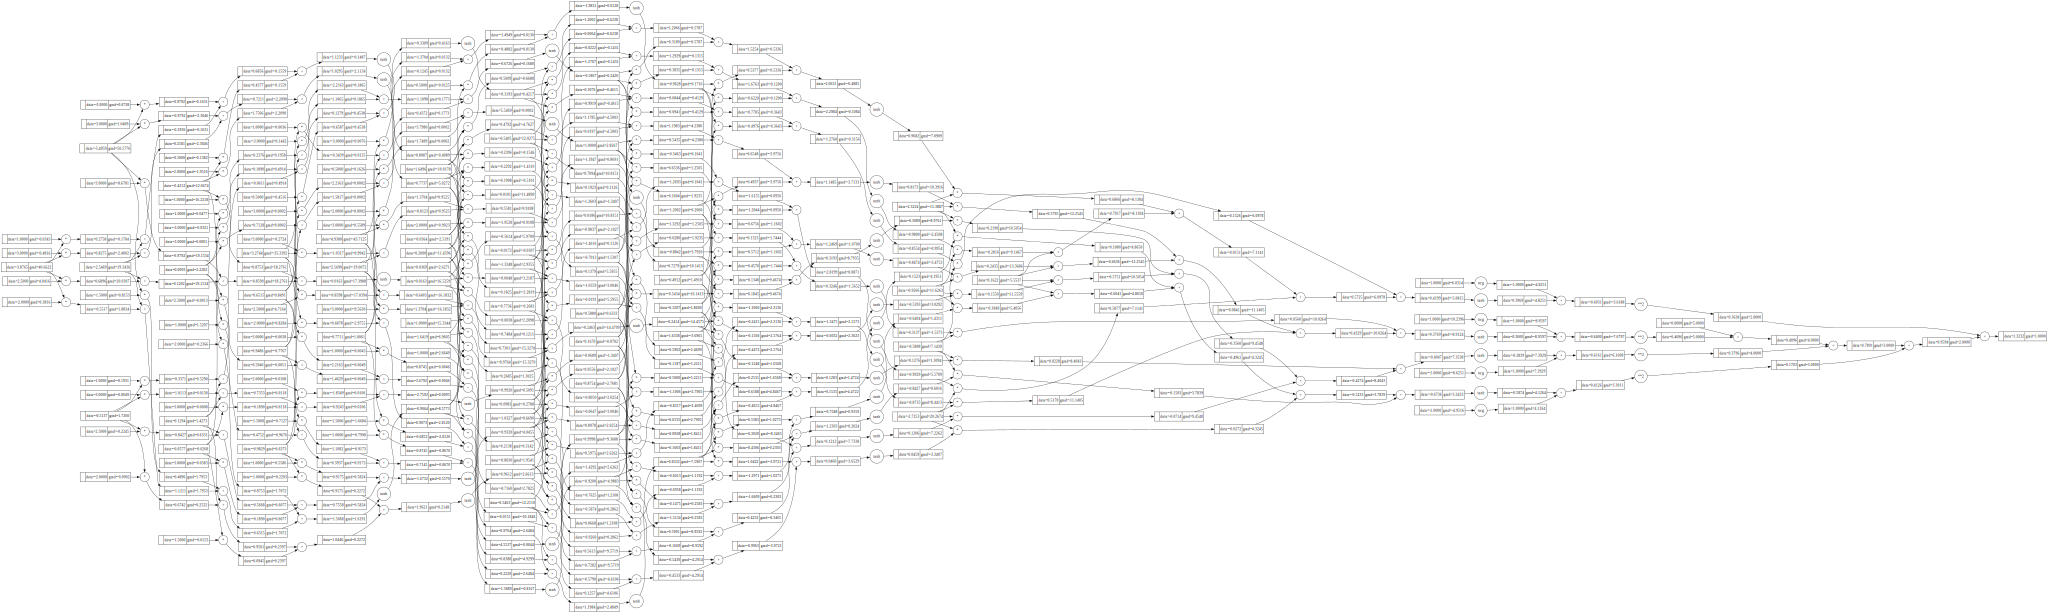

In [51]:
draw_dot(loss)